In [1]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [4]:
import nltk
import string
import re
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
def clean_text_NGram(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    token = re.split('\W+',text)
    text = " ".join([ps.stem(word) for word in token if word not in stopwords])
    return text

In [5]:
df['cleaned_text_NGram']= df['text'].apply(lambda x: clean_text_NGram(x))
df.head()

,id,keyword,location,text,target,cleaned_text_NGram
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order califor...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [6]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index

vocab_size=len(word_index)
print(vocab_size)
#word_index.items()

22700


In [7]:
df['text_len'] = df['text'].apply(lambda x: len(x) - x.count(" "))
print(df['text'][2])
df['text_len'].head()

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


0     57
1     32
2    112
3     57
4     72
Name: text_len, dtype: int64

In [8]:
# Padding data

max_len = 32
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print('sequences: ',sequences[0:5])
print('padded: ',padded[0:5])

sequences:  [[119, 4633, 24, 4, 868, 8, 21, 263, 138, 1619, 4634, 89, 40], [189, 45, 229, 799, 6954, 6955, 1404], [40, 1751, 1620, 7, 6956, 6, 6957, 24, 136, 6958, 20, 1752, 39, 441, 256, 57, 2158, 6, 714, 1405, 24, 1106], [835, 2921, 59, 4635, 1500, 256, 1405, 6, 96], [34, 100, 1221, 21, 320, 22, 6959, 2159, 30, 271, 22, 1500, 6960, 69, 5, 187]]
padded:  [[ 119 4633   24    4  868    8   21  263  138 1619 4634   89   40    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 189   45  229  799 6954 6955 1404    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  40 1751 1620    7 6956    6 6957   24  136 6958   20 1752   39  441
   256   57 2158    6  714 1405   24 1106    0    0    0    0    0    0
     0    0    0    0]
 [ 835 2921   59 4635 1500  256 1405    6   96    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   

In [9]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['target'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['target'].values[split_n:]

In [10]:
# Import tensor representations for words
embeddings_index = {};
embedding_dim =200
with io.open('glove.6B/glove.6B.200d.txt',encoding='utf8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

200


In [11]:
# Build the architecture of the model
     
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size+1,embedding_dim, weights=[embeddings_matrix], trainable=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=4),
#     tf.keras.layers.LSTM(20, return_sequences=True),
#     tf.keras.layers.LSTM(20),
#     tf.keras.layers.Dropout(0.2),  
#     tf.keras.layers.Dense(512),
#     tf.keras.layers.Dropout(0.3),  
#     tf.keras.layers.Dense(256),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len,weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [12]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=20, batch_size=100, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 200)           4540200   
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 32)            27776     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                2624      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

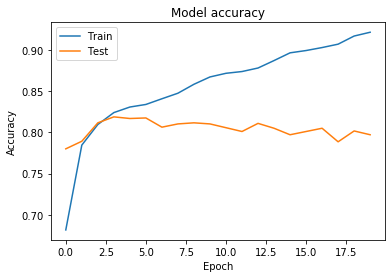

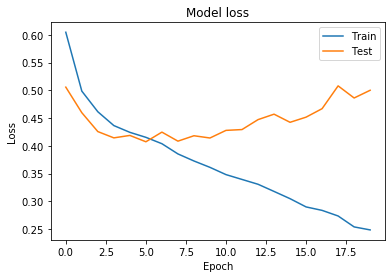

In [13]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('loss.png')
plt.show()


In [39]:
# create a script to make analysis for the output. 
import numpy as np
n = 100
X_test = list(df.head(100)['text'])
preds = preds = [np.random.binomial(1, 0.4) for i in range(100)]
y_test = preds = [np.random.binomial(1, 0.3) for i in range(100)]



In [66]:
#Extract instances for different groups through the classifier.
false_negative = [X_test[i] for i in range(len(X_test)) if (preds[i]==1) & (y_test[i]==0)]
false_positive = [X_test[i] for i in range(len(X_test)) if (preds[i]==0) & (y_test[i]==1)]
true_negative = [X_test[i] for i in range(len(X_test)) if (preds[i]==0) & (y_test[i]==0)]
true_positive = [X_test[i] for i in range(len(X_test)) if (preds[i]==0) & (y_test[i]==0)]
# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        30

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

[[70  0]
 [ 0 30]]


In [ ]:
#Print different classes

In [62]:
#print histogram of len
def histoprint(List, name=None):
    import matplotlib.pyplot as plt
    from statistics import mean
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))
    ccount = [len(x) for x in List]
    ax1.hist(ccount,color = 'red')
    ax1.set_title('Character count of {}'.format(name))
    wcount = [len(x.split()) for x in List]
    ax2.hist(wcount,color = 'blue')
    ax2.set_title('Word count of {}'.format(name))
    avlen = [ round(mean([len(y) for y in x.split()])) for x in List]
    ax3.hist(avlen,color = 'green')
    ax3.set_title('Averange word lengh of {}'.format(name))
    plt.show()
    return ax1, ax2, ax3

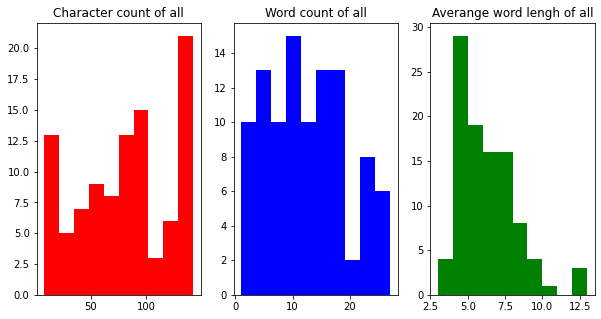

(<matplotlib.axes._subplots.AxesSubplot at 0x7f83d80d7a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f83d81e7400>)

In [63]:
histoprint(X_test, name='all')

In [ ]:
#Most common words
##First, create a corpus for the whole sets

##Second, for each class, loop through all instances to count the corpus vector.
##Third, for each class display n most common words, and the number of occurance for each of these words.

In [ ]:
#PCA or tSNE